In [33]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot
import awkward as ak
from pathlib import Path
import joblib

import mplhep as hep

hep.style.use(hep.style.ATLAS)

from typing import Dict, List
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Prepare Samples

In [4]:
merged_sig_path = "./merged_decorated_sig.pkl"
merged_bkg_path = "./merged_decorated_bkg.pkl"

merged_sig = joblib.load(merged_sig_path)
merged_bkg = joblib.load(merged_bkg_path)

In [6]:
merged_sig["target"] = np.ones(len(merged_sig))
merged_bkg["target"] = np.zeros(len(merged_bkg))

In [8]:
merged_sig.head()

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep3WeightZ,Lep1WeightW,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level,Ht,pSignal_GM,target
3,0,450765,3,1516,0.783916,0.0,-0.079258,-0.101105,187.706635,144.789856,...,0.997051,0.969956,0.990138,0.995931,123,123,123,508.242188,0.781384,1.0
11,0,450765,2,1516,0.783916,0.0,-0.053379,-0.068093,270.459198,156.205460,...,0.988552,0.996840,0.998581,0.978706,123,123,123,295.828552,0.887640,1.0
14,0,450765,3,1516,0.783916,0.0,0.042182,0.053809,196.065414,165.009293,...,0.999236,0.971638,0.966696,0.998496,123,123,123,274.689301,0.922267,1.0
16,0,450765,2,1516,0.783916,0.0,-0.066834,-0.085256,200.703903,140.544388,...,0.956663,0.995598,0.981509,0.902356,123,123,123,288.953735,0.939477,1.0
22,0,450765,1,1516,0.783916,0.0,0.072323,0.092259,221.749603,144.889526,...,0.999727,0.990660,0.975106,0.995559,123,123,123,261.893311,0.621475,1.0


In [9]:
merged_bkg.head()

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep3WeightZ,Lep1WeightW,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level,Ht,pSignal_GM,target
0,0,364253,1,1516,0.03081,-1.0,0.004270,0.138590,307.253082,224.885284,...,0.996026,0.984322,0.988816,0.999972,123,123,123,302.934784,0.084021,0.0
3,0,364253,1,1516,0.03081,-1.0,0.003436,0.111508,264.512421,162.948868,...,0.976912,0.984519,0.966683,0.972876,123,123,123,564.105957,0.474402,0.0
7,0,364253,2,1516,0.03081,-1.0,0.001967,0.063848,581.739746,542.020996,...,0.994135,0.963180,0.991485,0.989407,123,123,123,1407.941895,0.055484,0.0
8,0,364253,1,1516,0.03081,-1.0,0.004380,0.142154,180.702271,126.432777,...,0.996336,0.982291,0.992726,0.993438,123,123,123,449.234253,0.561984,0.0
9,0,364253,1,1516,0.03081,-1.0,0.003606,0.117033,421.647491,330.038269,...,0.989995,0.997536,0.987993,0.990398,122,123,123,235.120377,0.063376,0.0


In [10]:
len(merged_sig)

913467

In [11]:
len(merged_bkg)

1145516

In [15]:
sample = pd.concat([merged_sig, merged_bkg])

In [16]:
len(sample)

2058983

In [18]:
joblib.dump(sample, "training_sample.pkl")

['training_sample.pkl']

# Training

In [17]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.1, random_state=456
)
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.1 / 0.9, random_state=789
)

In [19]:
training_features = [
    "M_jj",
    "Dphi_jj",
    "Jet1Eta",
    "Eta_W",
    "Eta_Z",
    "ZetaLep",
    "Met",
    "Ht",
]

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train[training_features])
X_train[training_features] = scaler.transform(X_train[training_features])
X_test[training_features] = scaler.transform(X_test[training_features])

In [32]:
clf = MLPClassifier(
    solver="adam",
    alpha=1e-5,
    learning_rate="constant",
    learning_rate_init=0.01,
    hidden_layer_sizes=(50, 50),
    random_state=42,
    verbose=True,
    max_iter=100,
    validation_fraction=0.1,
    early_stopping=True,
    n_iter_no_change=10,
)

clf.fit(X_train[training_features], y_train)

Iteration 1, loss = 0.31691215
Validation score: 0.872377
Iteration 2, loss = 0.31078064
Validation score: 0.871672
Iteration 3, loss = 0.30957416
Validation score: 0.873293
Iteration 4, loss = 0.30881603
Validation score: 0.872959
Iteration 5, loss = 0.30823462
Validation score: 0.872528
Iteration 6, loss = 0.30788632
Validation score: 0.873743
Iteration 7, loss = 0.30768700
Validation score: 0.873008
Iteration 8, loss = 0.30748946
Validation score: 0.874471
Iteration 9, loss = 0.30718100
Validation score: 0.874423
Iteration 10, loss = 0.30722020
Validation score: 0.873985
Iteration 11, loss = 0.30686788
Validation score: 0.873755
Iteration 12, loss = 0.30662147
Validation score: 0.873919
Iteration 13, loss = 0.30643185
Validation score: 0.874046
Iteration 14, loss = 0.30656061
Validation score: 0.874410
Iteration 15, loss = 0.30645825
Validation score: 0.873870
Iteration 16, loss = 0.30657145
Validation score: 0.874240
Iteration 17, loss = 0.30642069
Validation score: 0.874902
Iterat

MLPClassifier(alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=100, random_state=42,
              verbose=True)

# Performance

## Loss 

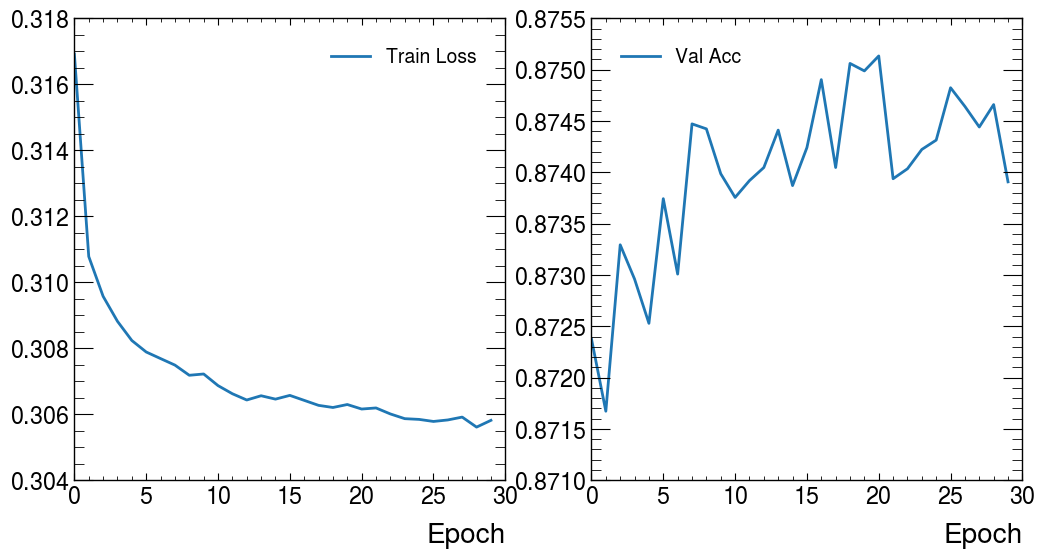

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(clf.loss_curve_, label="Train Loss")
ax[1].plot(clf.validation_scores_, label="Val Acc")
ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
fig.savefig("./plots_ml/MLP_training_curve.png")

In [129]:
clf.feature_names_in_

array(['M_jj', 'Dphi_jj', 'Jet1Eta', 'Eta_W', 'Eta_Z', 'ZetaLep', 'Met',
       'Ht'], dtype=object)

## Distribution of testing

In [27]:
y_test_decisions = clf.predict_proba(X_test[training_features])[:, 1]

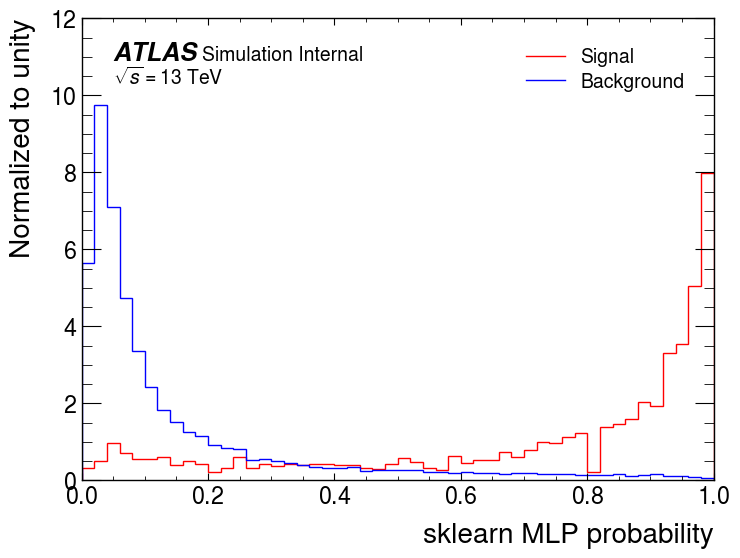

In [35]:
event_weight_idx = X.columns.get_loc("WeightNormalized")
y_test_sig_id = np.where(y_test == 1)[0]
y_test_bkg_id = np.where(y_test == 0)[0]

mlp_score_bin_edges = np.linspace(0, 1, 51)

sig_bin_contents, sig_bin_edges = np.histogram(
    y_test_decisions[y_test_sig_id],
    weights=X_test.iloc[y_test_sig_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)
bkg_bin_contents, bkg_bin_edges = np.histogram(
    y_test_decisions[y_test_bkg_id],
    weights=X_test.iloc[y_test_bkg_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)

fig, ax = plt.subplots()
hep.histplot(
    sig_bin_contents, sig_bin_edges, label="Signal", ax=ax, color="red"
)
hep.histplot(
    bkg_bin_contents,
    bkg_bin_edges,
    label="Background",
    ax=ax,
    color="blue",
)

hep.atlas.label("Internal", data=False)
hep.atlas.set_ylabel("Normalized to unity")
hep.atlas.set_xlabel("sklearn MLP probability")
ax.legend()
fig.savefig("./plots_ml/sklearn_MLP_score.png")

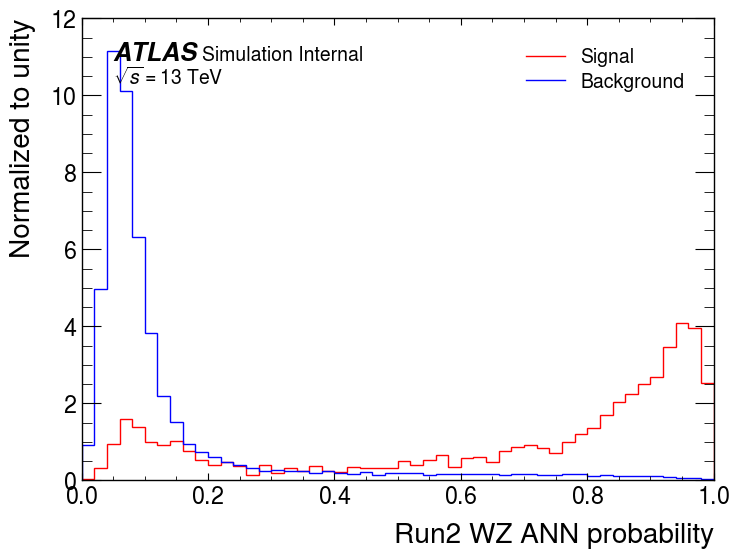

In [41]:
pSignal_GM_idx = X.columns.get_loc("pSignal_GM")
sig_bin_contents, sig_bin_edges = np.histogram(
    X_test.iloc[y_test_sig_id, pSignal_GM_idx],
    weights=X_test.iloc[y_test_sig_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)
bkg_bin_contents, bkg_bin_edges = np.histogram(
    X_test.iloc[y_test_bkg_id, pSignal_GM_idx],
    weights=X_test.iloc[y_test_bkg_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)

fig, ax = plt.subplots()
hep.histplot(
    sig_bin_contents, sig_bin_edges, label="Signal", ax=ax, color="red"
)
hep.histplot(
    bkg_bin_contents,
    bkg_bin_edges,
    label="Background",
    ax=ax,
    color="blue",
)

hep.atlas.label("Internal", data=False)
hep.atlas.set_ylabel("Normalized to unity")
hep.atlas.set_xlabel("Run2 WZ ANN probability")
ax.legend()
fig.savefig("./plots_ml/run2wz_ANN_score.png")

## ROC

In [139]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


def Draw_ROC(y_true, y_sklearn_mlp, y_run2_wz_prob, X_weight):
    # Compute ROC curve and area under the curve
    fpr_skl_mlp, tpr_skl_mlp, thresholds = roc_curve(
        y_true, y_sklearn_mlp, sample_weight=X_weight
    )
    fpr_run2_ann, tpr_run2_ann, thresholds_run2_ann = roc_curve(
        y_true, y_run2_wz_prob, sample_weight=X_weight
    )

    # Note: x is neither increasing nor decreasing :
    # because of event weights, fpr is not increasing or decreasing
    sorted_index = np.argsort(fpr_skl_mlp)
    fpr_skl_mlp = fpr_skl_mlp[sorted_index]
    tpr_skl_mlp = tpr_skl_mlp[sorted_index]

    sorted_index = np.argsort(fpr_run2_ann)
    fpr_run2_ann = fpr_run2_ann[sorted_index]
    tpr_run2_ann = tpr_run2_ann[sorted_index]

    roc_auc_skl_mlp = auc(fpr_skl_mlp, tpr_skl_mlp)
    roc_auc_run2_ann = auc(fpr_run2_ann, tpr_run2_ann)

    fig, ax = plt.subplots()
    ax.plot(
        fpr_skl_mlp,
        tpr_skl_mlp,
        lw=1,
        label="ROC_sklearn_MLP (area = %0.3f)" % (roc_auc_skl_mlp),
    )
    ax.plot(
        fpr_run2_ann,
        tpr_run2_ann,
        lw=1,
        label="ROC_run2_ANN (area = %0.3f)" % (roc_auc_run2_ann),
    )

    ax.plot([1.0, 0.0], [1.0, 0.0], "--", color=(0.6, 0.6, 0.6), label="Luck")
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC with Event Weights")
    ax.legend(loc="lower right")
    ax.grid()
    hep.atlas.label("Internal", data=False)
    fig.savefig("./plots_ml/ROC_compare_eventweight.png")

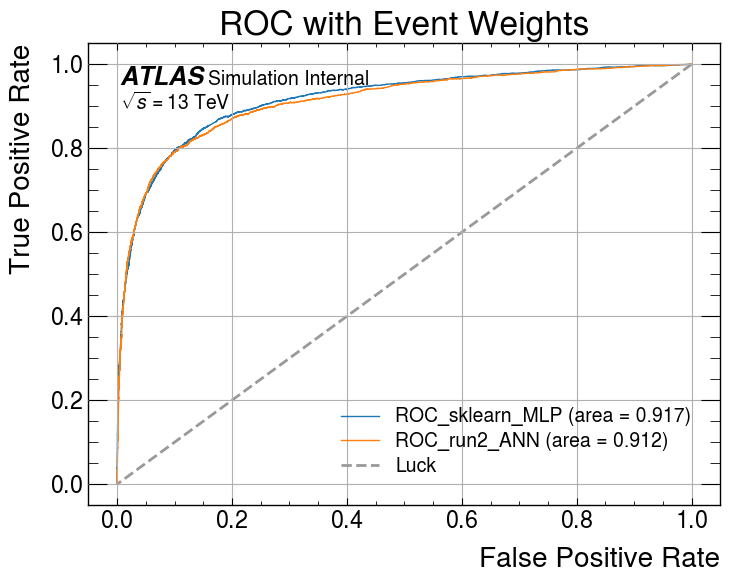

In [140]:
Draw_ROC(
    y_true=y_test,
    y_sklearn_mlp=y_test_decisions,
    y_run2_wz_prob=X_test.iloc[:, pSignal_GM_idx],
    X_weight=X_test.iloc[:, event_weight_idx],
)

## Overtraining

In [130]:
y_train_decisions = clf.predict_proba(X_train[training_features])[:, 1]

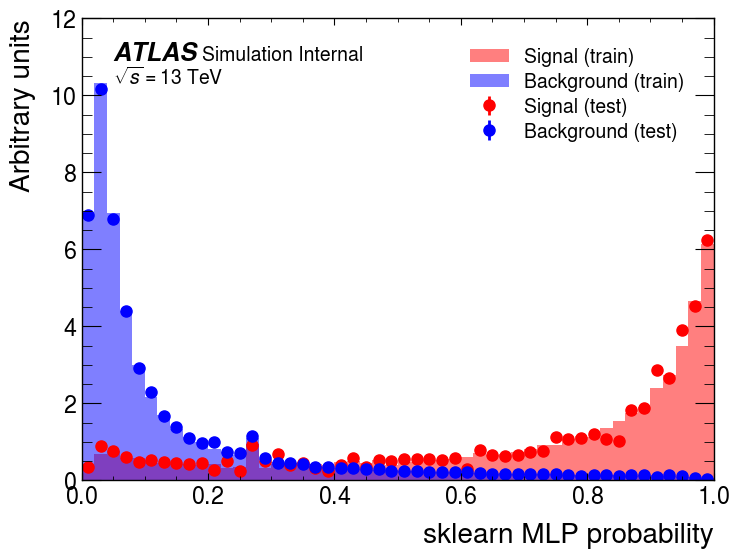

In [138]:
event_weight_idx = X.columns.get_loc("WeightNormalized")
y_test_sig_id = np.where(y_test == 1)[0]
y_test_bkg_id = np.where(y_test == 0)[0]
y_train_sig_id = np.where(y_train == 1)[0]
y_train_bkg_id = np.where(y_train == 0)[0]

y_train_decisions = clf.predict_proba(X_train[training_features])[:, 1]
y_train_sig_decisions = y_train_decisions[y_train_sig_id]
y_train_bkg_decisions = y_train_decisions[y_train_bkg_id]
y_test_decisions = clf.predict_proba(X_test[training_features])[:, 1]
y_test_sig_decisions = y_test_decisions[y_test_sig_id]
y_test_bkg_decisions = y_test_decisions[y_test_bkg_id]

decisions = []
decisions.append(y_train_sig_decisions)
decisions.append(y_train_bkg_decisions)
decisions.append(y_test_sig_decisions)
decisions.append(y_test_bkg_decisions)


custom_bins = np.linspace(0, 1, 51)
custom_bin_width = custom_bins[1] - custom_bins[0]
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(
    decisions[0],
    weights=X_train.iloc[np.where(y_train == 1)[0], event_weight_idx],
    color="r",
    alpha=0.5,
    bins=custom_bins,
    histtype="stepfilled",
    density=True,
    label="Signal (train)",
)
ax.hist(
    decisions[1],
    weights=X_train.iloc[np.where(y_train == 0)[0], event_weight_idx],
    color="b",
    alpha=0.5,
    bins=custom_bins,
    histtype="stepfilled",
    density=True,
    label="Background (train)",
)

hist, bins = np.histogram(
    decisions[2],
    weights=X_test.iloc[np.where(y_test == 1)[0], event_weight_idx],
    bins=custom_bins,
    density=True,
)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(
    custom_bin_center, hist, yerr=err, fmt="o", c="r", label="Signal (test)"
)

hist, bins = np.histogram(
    decisions[3],
    weights=X_test.iloc[np.where(y_test == 0)[0], event_weight_idx],
    bins=custom_bins,
    density=True,
)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

ax.errorbar(
    custom_bin_center,
    hist,
    yerr=err,
    fmt="o",
    c="b",
    label="Background (test)",
)
ax.set_xlabel("sklearn MLP probability")
ax.set_ylabel("Arbitrary units")
ax.legend(loc="best")
ax.set_label("Overtraining test")

hep.atlas.label("Internal", data=False)
fig.savefig("./plots_ml/Overtraining_test.png")